# Task 7: Dimensionality Reduction & Stock Price Prediction
 
 
1. **Dimensionality Reduction** using PCA on the classic Iris dataset.
2. **Stock Price Prediction** using an ARIMA time‑series model.

In [1]:
!pip -q install numpy pandas matplotlib seaborn scikit-learn statsmodels pmdarima

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pmdarima as pm
%matplotlib inline

## Part 1: Dimensionality Reduction with PCA

In [3]:
# Load Iris dataset
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data
y = iris.target
feature_names = iris.feature_names

# Standardize features
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# PCA to 2 components
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_std)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['target'] = y
print(pca_df.head())

        PC1       PC2  target
0 -2.264703  0.480027       0
1 -2.080961 -0.674134       0
2 -2.364229 -0.341908       0
3 -2.299384 -0.597395       0
4 -2.389842  0.646835       0


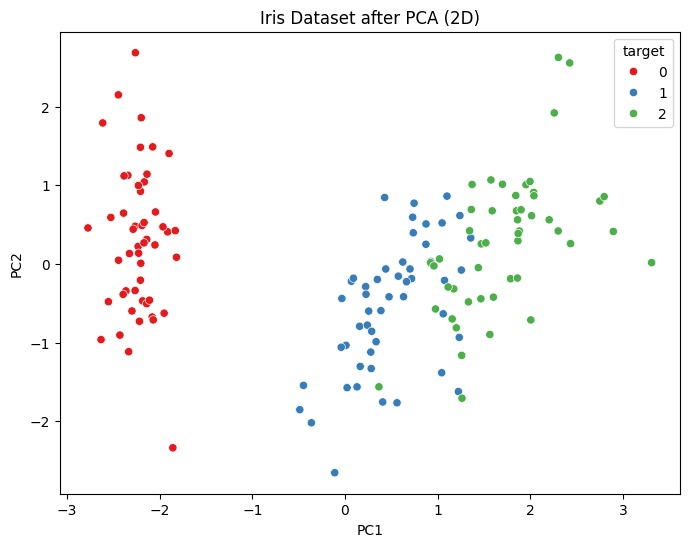

In [4]:
# Scatter plot of the two principal components
plt.figure(figsize=(8,6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='target', palette='Set1')
plt.title('Iris Dataset after PCA (2D)')
plt.show()

## Part 2: Stock Price Prediction with ARIMA

In [21]:
stock_df = pd.read_csv('TCS_historical_data.csv')

stock_df=stock_df[['DATE','CLOSE','OPEN','VOLUME']]
 
stock_df['DATE'] = pd.to_datetime(stock_df['DATE'], errors='coerce')
stock_df        = (stock_df
                   .dropna(subset=['DATE'])     # drop rows with bad dates
                   .sort_values('DATE')
                   .set_index('DATE')
                   .ffill())                    # forward-fill any small gaps

display(stock_df.head())

,CLOSE,OPEN,VOLUME
DATE,,,
2010-01-04,751.65,754.80,981841
2010-01-05,751.85,755.00,1007244
2010-01-06,734.85,751.85,1674588
2010-01-07,714.40,735.50,3237446
2010-01-08,699.80,716.00,3024089


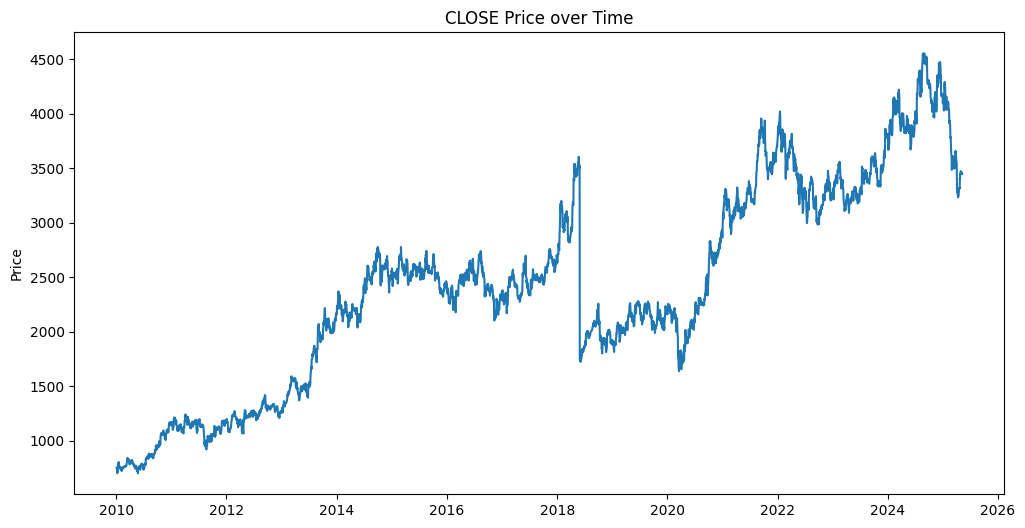

In [22]:


# Plot CLOSE price over time
plt.figure(figsize=(12,6))
plt.plot(stock_df['CLOSE'])
plt.title('CLOSE Price over Time')
plt.ylabel('Price')
plt.show()

In [23]:
# Feature engineering: 1‑day lag and 7‑day moving average
stock_df['Close_lag1'] = stock_df['CLOSE'].shift(1)
stock_df['MA7'] = stock_df['CLOSE'].rolling(window=7).mean()
stock_df = stock_df.dropna()
display(stock_df.tail())

,CLOSE,OPEN,VOLUME,Close_lag1,MA7
DATE,,,,,
2025-05-02,3444.7,3472.0,2115624,3453.7,3439.571429
2025-05-05,3454.3,3450.0,1284443,3444.7,3445.471429
2025-05-06,3460.0,3460.0,1324763,3454.3,3453.814286
2025-05-07,3445.1,3420.6,1477128,3460.0,3453.400000
2025-05-08,3448.9,3448.0,2543591,3445.1,3454.171429


In [24]:
# Train‑test split (last 20% for testing)
train_size = int(len(stock_df) * 0.8)
train, test = stock_df['CLOSE'][:train_size], stock_df['CLOSE'][train_size:]

In [25]:
# Auto‑select ARIMA parameters
auto_model = pm.auto_arima(train, seasonal=False, stepwise=True, suppress_warnings=True)
print('Chosen ARIMA order:', auto_model.order)

Chosen ARIMA order: (0, 1, 0)


In [26]:
# Fit ARIMA with chosen order
order = auto_model.order
model = ARIMA(train, order=order)
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  CLOSE   No. Observations:                 3049
Model:                 ARIMA(0, 1, 0)   Log Likelihood              -16044.116
Date:                Fri, 13 Jun 2025   AIC                          32090.233
Time:                        09:25:04   BIC                          32096.255
Sample:                             0   HQIC                         32092.397
                               - 3049                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2185.1294      3.035    719.940      0.000    2179.181    2191.078
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):          58856686.44
Prob(Q):                              0.95   Pr

c:\Users\pavan\anaconda3\envs\tf_clean\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\pavan\anaconda3\envs\tf_clean\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\pavan\anaconda3\envs\tf_clean\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [27]:
# Forecast over test horizon
forecast = model_fit.forecast(steps=len(test))

# Evaluation metrics
mae = mean_absolute_error(test, forecast)
rmse = mean_squared_error(test, forecast, squared=False)
mape = np.mean(np.abs((test - forecast)/test))*100
print(f'MAE: {mae:.4f}\nRMSE: {rmse:.4f}\nMAPE: {mape:.2f}%')

MAE: 360.4759
RMSE: 405.1104
MAPE: nan%


c:\Users\pavan\anaconda3\envs\tf_clean\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\pavan\anaconda3\envs\tf_clean\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\pavan\AppData\Local\Temp\ipykernel_14728\893461893.py:7: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((test - forecast)/test))*100


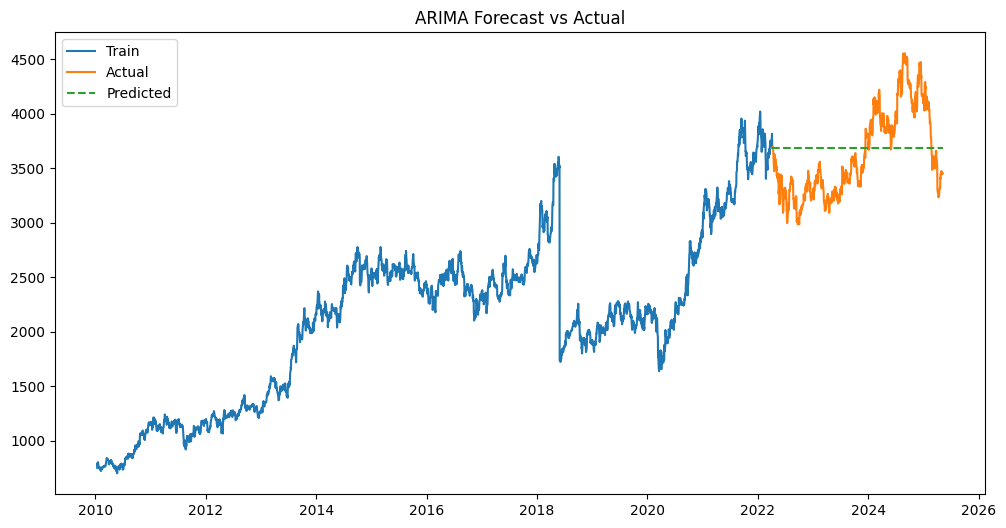

In [28]:
# Plot actual vs predicted prices
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, forecast, label='Predicted', linestyle='--')
plt.title('ARIMA Forecast vs Actual')
plt.legend()
plt.show()